# Thermal Model Workflow – From Calibration Data to Orbital Simulation

# STEP 1: Load FITS data

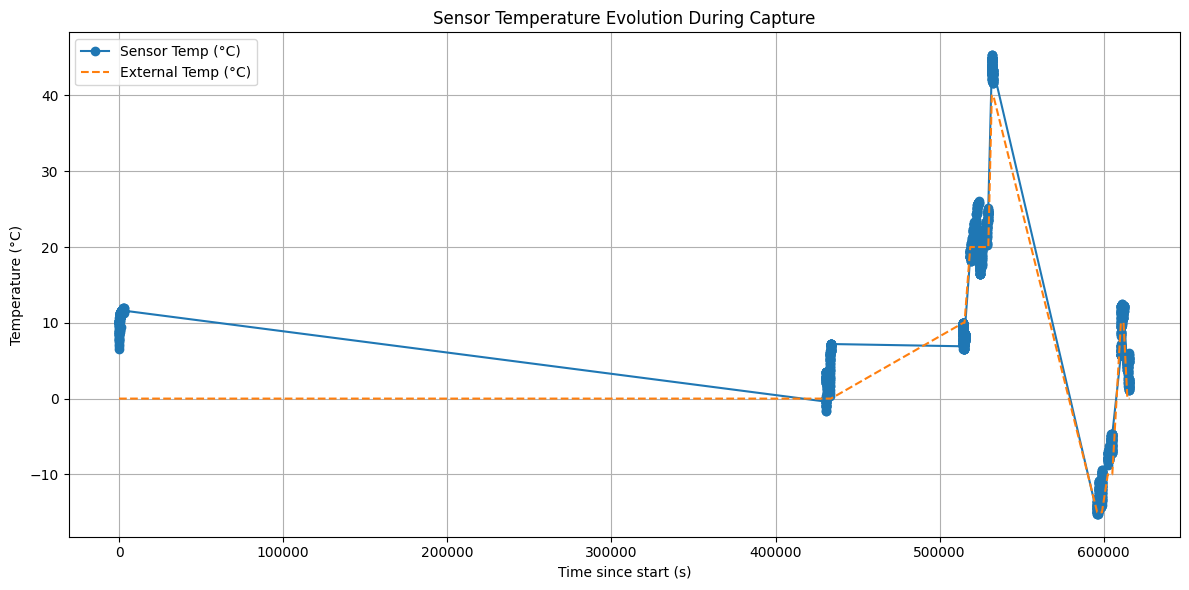


📈 Temperature Statistics:
count    1610.000000
mean       10.766273
std        14.666554
min       -15.200000
25%         2.375000
50%         9.700000
75%        19.600000
max        45.300000
Name: sensor_temp, dtype: float64


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from thermalmodel import ThermalModel

# Load raw FITS-based dataset
fits_path = "/locationtoyour/fits"  # <-- MODIFY THIS
model = ThermalModel()
df = model.extract_temperature_data_from_fits(fits_path)
model.plot_temperature_evolution(df)


## Step 2: Group by (external_temp, exposure_time)

In [2]:

# 2. Agrupar y excluir claves
grouped = model.group_by_external_temp_and_exptime(df)
exclude_keys = model.exclude_by_temperature(grouped, excluded_temps=[0])
exclude_keys += [(-15, 1), (-15, 2), (10, 1)]


## Step 3: Train and save the Thermal Model

In [3]:

# 3. Entrenar
interpolators, fit_df = model.build_interpolated_model(grouped, exclude_keys=exclude_keys)
model.save("./temperature_model/")


## Step 4: Load the model and simulate sensor temperature in orbit

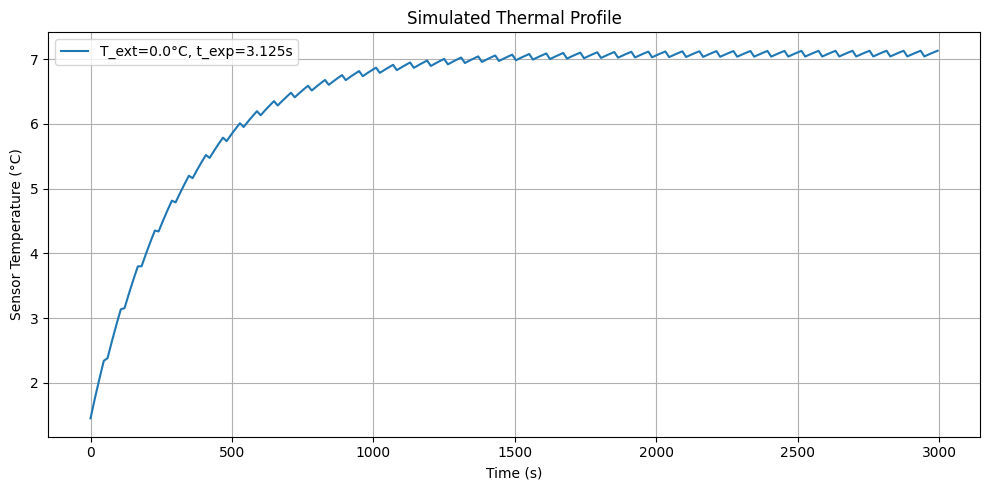

In [4]:

model = ThermalModel()
model.load("temperature_model/")

# Simulate for specific orbit case
external_temp = 0.0
exposure_time = 3.125
times, temps = model.simulate(
    external_temp=external_temp,
    exposure_time=exposure_time,
    n_frames=16,
    frame_pause=0.01,
    burst_pause=10,
    n_bursts=50,
    only_when_exposing=True
)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(times, temps, label=f"T_ext={external_temp}°C, t_exp={exposure_time}s")
plt.xlabel("Time (s)")
plt.ylabel("Sensor Temperature (°C)")
plt.title("Simulated Thermal Profile")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


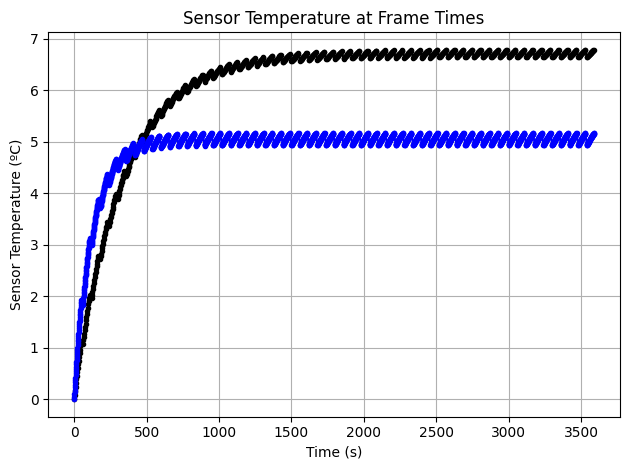

In [5]:
from thermalmodel import ThermalModel
from cielo.utilities.driver_photsim.time_frame import Time_frame  # Asegúrate de tener esta clase cargada

# Crear simulador temporal
tf16 = Time_frame(
    coordinates_length=60,
    image_per_coord=16,
    exposition_time=3.125 / 60,   # en minutos
    pointing_time=10 / 60         # en minutos
)

# Asignar temperatura usando el modelo térmico ya entrenado
times16, temps16 = model.map_temperatures_to_custom_times(
    time_model=tf16,
    external_temp=0.0,
    exposure_time=3.125
)

# Crear simulador temporal
tf50 = Time_frame(
    coordinates_length=60,
    image_per_coord=50,
    exposition_time=1 / 60,   # en minutos
    pointing_time=10 / 60         # en minutos
)

# Asignar temperatura usando el modelo térmico ya entrenado
times50, temps50 = model.map_temperatures_to_custom_times(
    time_model=tf50,
    external_temp=0.0,
    exposure_time=1
)
# Visualizar
plt.plot(times16, temps16, ".-k", label="MODE A: t_exp=3.125 s")
plt.plot(times50, temps50, ".-b", label="MODE A: t_exp=1 s")
plt.xlabel("Time (s)")
plt.ylabel("Sensor Temperature (ºC)")
plt.title("Sensor Temperature at Frame Times")
plt.grid()
plt.tight_layout()
plt.show()

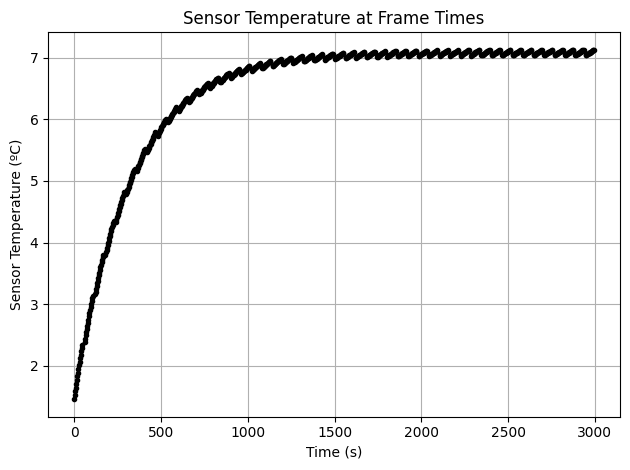

In [6]:
# Visualizar
plt.plot(times, temps, ".-k")
plt.xlabel("Time (s)")
plt.ylabel("Sensor Temperature (ºC)")
plt.title("Sensor Temperature at Frame Times")
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
from timeframev2.timeframe import Time_frame

In [8]:
tf = Time_frame(
    coordinates_length=105,
    image_per_coord=16,
    exposition_time=50/60,          # minutos por imagen
    pointing_time=10/60,          # minutos entre campos
    daily_pauses=2,             # dos pausas por día
    pause_duration=10,          # duración de cada pausa
    min_pause_separation=20     # separación mínima de 90 minutos entre pausas
)

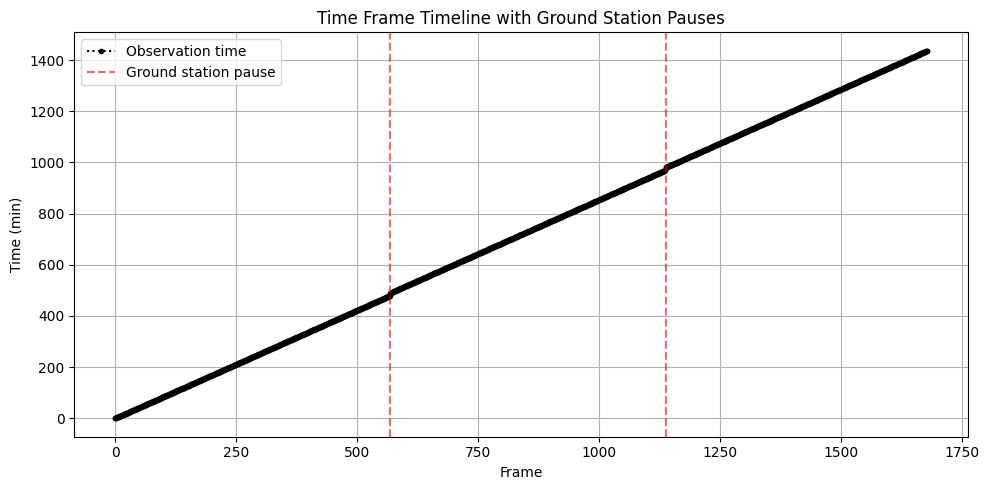

In [9]:
tf.plot()

In [10]:
# Asignar temperatura usando el modelo térmico ya entrenado
timesv2, tempsv2 = model.map_temperatures_to_custom_times(
    time_model=tf,
    external_temp=0.0,
    exposure_time=50/16
)

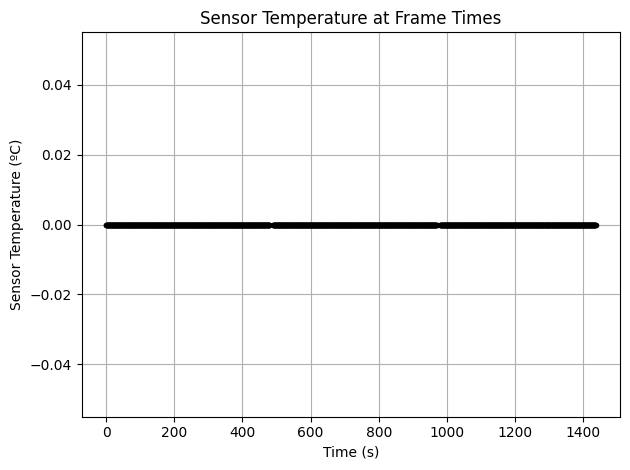

In [11]:
ind = -1
plt.plot(timesv2[:ind]/60, tempsv2[:ind], ".-k", label="MODE A: t_exp=3.125 s")

plt.xlabel("Time (s)")
plt.ylabel("Sensor Temperature (ºC)")
plt.title("Sensor Temperature at Frame Times")
plt.grid()
plt.tight_layout()
plt.show()

In [12]:
import numpy as np

Revisar y visualizar los intervalos entre imágenes para confirmar cuándo hay pausas largas
dt_sec = np.diff(timeline_sec)
threshold = exposition_time * (60 +0.5)   # umbral para considerar una pausa larga

Clasificar si se aplicó heating o cooling en cada intervalo
heating = dt_sec <= threshold
cooling = dt_sec > threshold

Mostrar cuántos intervalos se clasifican como pausas
num_cooling = np.sum(cooling)
num_heating = np.sum(heating)

Visualizar los intervalos clasificados
plt.figure(figsize=(12, 4))
plt.plot(dt_sec, label="Δt between frames (s)")
plt.axhline(y=threshold, color="red", linestyle="--", label="Cooling threshold")
plt.title("Time Between Frames with Heating/Cooling Classification")
plt.xlabel("Frame Index")
plt.ylabel("Δt (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

num_cooling, num_heating, threshold


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import pandas as pd

# Define paths
model_path = Path("/home/gabriel/Documents/photsat/2025/mission_analysis/new_simulator_noise_addition_model/temperature_model")  # Adjust path if needed

# Load previously saved model
with open(model_path / "interpolators.pkl", "rb") as f:
    interpolators = pickle.load(f)
fit_df = pd.read_csv(model_path / "fit_parameters.csv")

# Extract a representative fit for debugging
external_temp = 0.0
exposure_time = 50 / 16
point = np.array([[external_temp, exposure_time]])
fit_params = {
    "T_ext": interpolators["T_ext"](point)[0],
    "T_max": interpolators["T_max"](point)[0],
    "tau": interpolators["tau"](point)[0],
}

# Simulate frame timeline
from math import radians, degrees, sin, cos, fabs, atan2, sqrt
rng = np.random.default_rng(42)

coordinates_length = 105
image_per_coord = 16
exposition_time = exposure_time  # min
pointing_time = 10 / 60  # min
daily_pauses = 2
pause_duration = 10
min_pause_separation = 20

# Generate fixed-pointing timeline
timeline = []
mov = 0
for i in range(coordinates_length * image_per_coord):
    if i % image_per_coord == 0 and i > 0:
        mov += pointing_time
    timeline.append(i * exposition_time + mov)

# Convert to seconds
timeline_sec = np.array(timeline) * 60.0

# Simulate thermal evolution manually
T_ext = external_temp
T_max = fit_params["T_max"]
tau = fit_params["tau"]
tau_cool = 2 * tau

def heat(T_prev, dt):
    return T_ext + (T_prev - T_ext) * np.exp(-dt / tau) + (T_max - T_ext) * (1 - np.exp(-dt / tau))

def cool(T_prev, dt):
    return T_ext + (T_prev - T_ext) * np.exp(-dt / tau_cool)

temps = [T_ext]
T_curr = T_ext
last_time = timeline_sec[0]


for t in timeline_sec[1:]:
    dt = t - last_time
    T_curr = heat(T_curr, dt) if dt <= exposition_time * (60+0.5) else cool(T_curr, dt)
    temps.append(T_curr)
    last_time = t



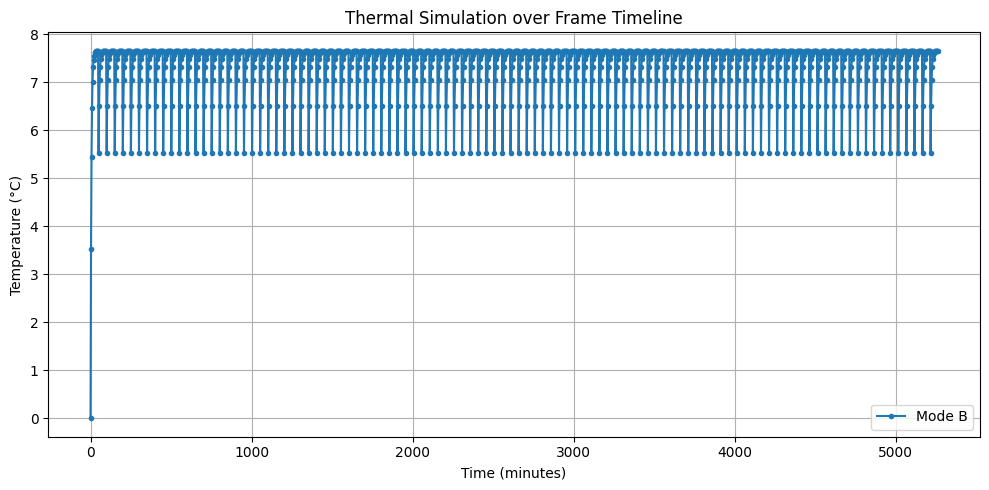

In [14]:
ind = -1
plt.figure(figsize=(10, 5))
plt.plot((timeline_sec / 60) [:ind], temps[:ind], label="Mode B", marker='.')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Thermal Simulation over Frame Timeline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

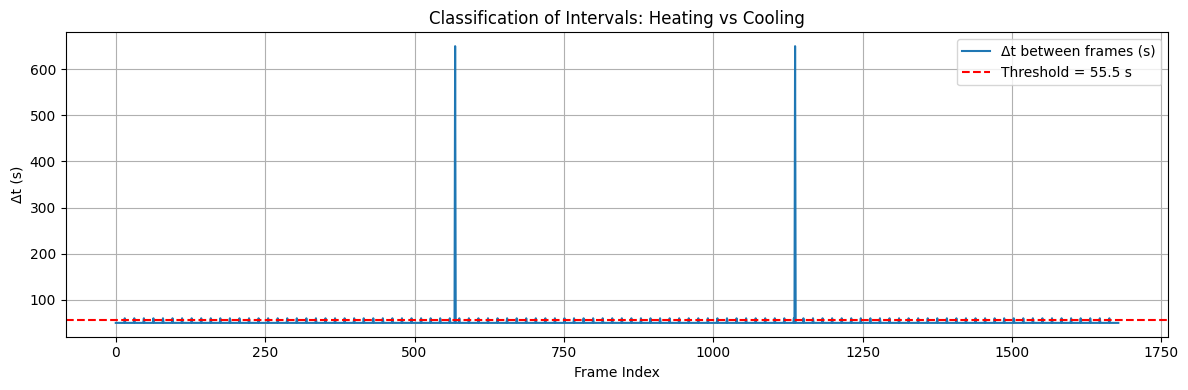

In [15]:
times_sec, temperatures, threshold, n_cool, n_heat = model.simulate_temperature_from_custom_timeline(
    time_model=tf,
    external_temp=0.0,
    exposure_time_min=50 / 16,
    show_plot=True,
    threshold_buffer_min=-2.2
)


In [16]:
threshold

55.499999999999986

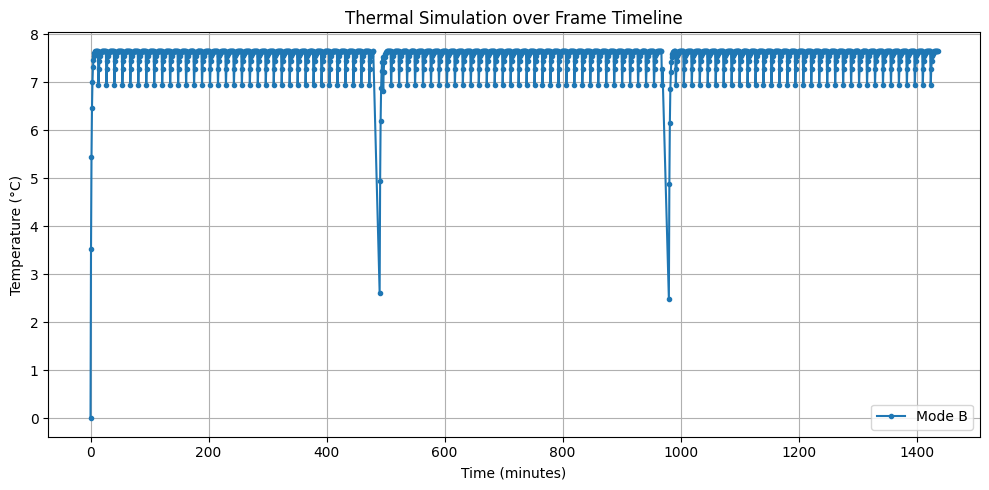

In [17]:
ind = -1
plt.figure(figsize=(10, 5))
plt.plot((times_sec / 60) [:ind], temperatures[:ind], label="Mode B", marker='.')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Thermal Simulation over Frame Timeline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# MODO A: 50 imágenes de 1s → 50s = 50/60 min total
tf_A = Time_frame(
    coordinates_length=1440,
    image_per_coord=50,
    exposition_time=1/60,           # minutos por imagen
    pointing_time=10/60,             # minutos entre campos
    daily_pauses=2,
    pause_duration=10,
    min_pause_separation=20
)

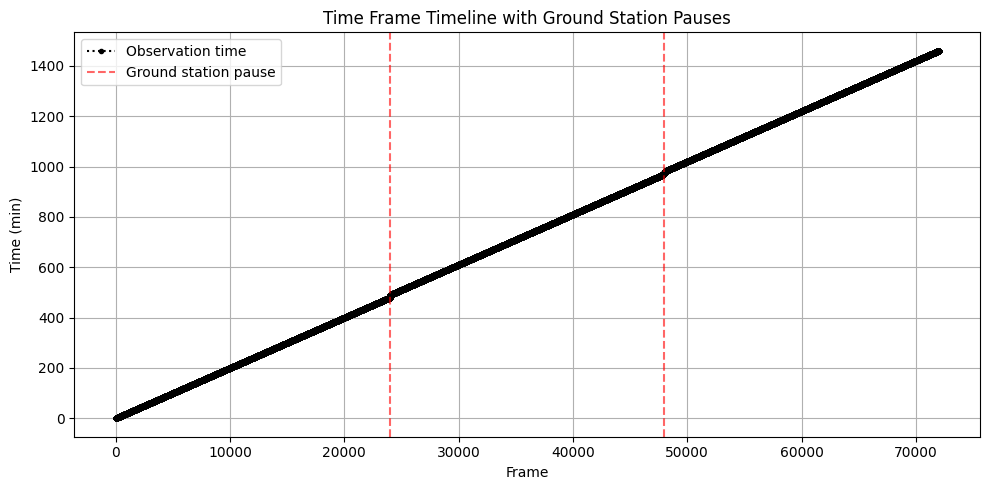

In [19]:
tf_A.plot()

In [20]:
tf_A.max_frames_and_fields_per_day()

📈 Observation budget per day:
→ Daily available time: 1420.0 min
→ Time per frame: 0.020 min
→ Max frames per day: 70999
→ Frames per coordinate: 50
→ Max fields per day (final images): 1419


(70999, 1419)

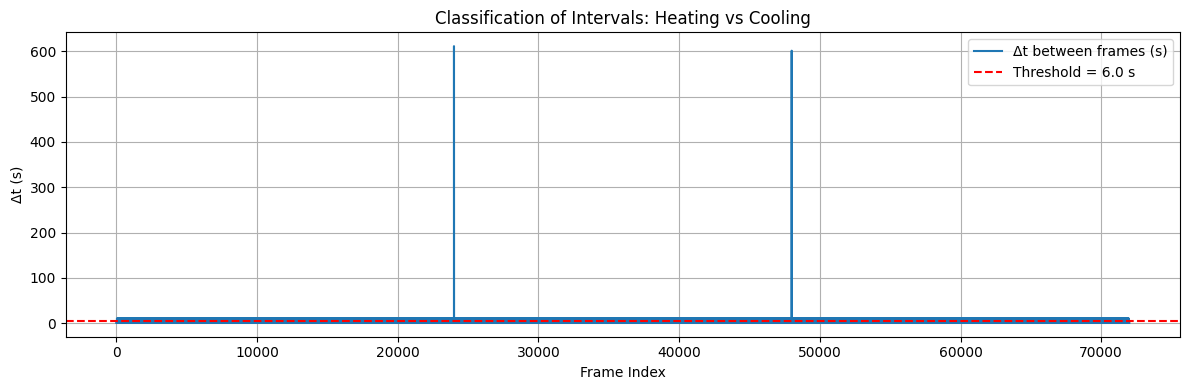

In [21]:
times_A, temps_A, _, _, _ = model.simulate_temperature_from_custom_timeline(
    time_model=tf_A,
    external_temp=0.0,
    exposure_time_min=1,
    show_plot=True,
    threshold_buffer_min=0.1-1
)

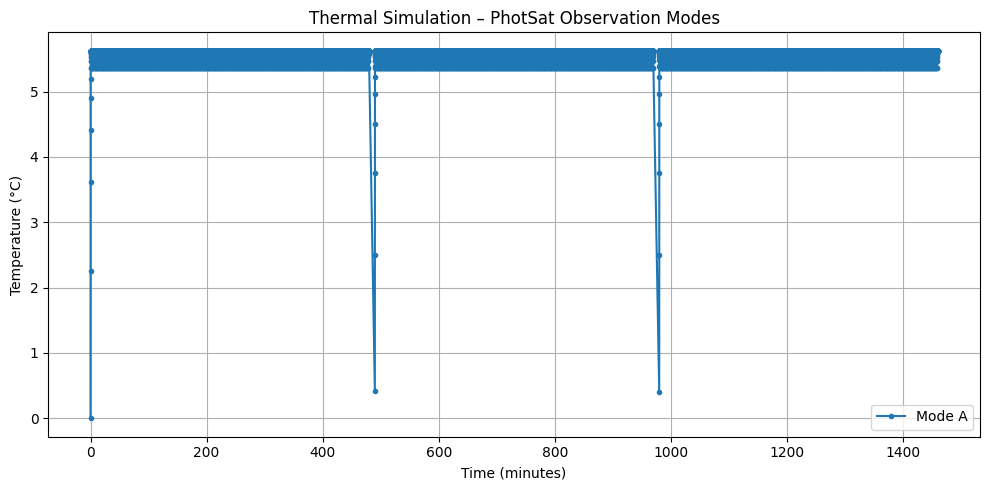

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(times_A/60, temps_A, label="Mode A", marker='.')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Thermal Simulation – PhotSat Observation Modes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# MODO B: 16 imágenes de 3.125s → 50s = 50/60 min total
tf_B = Time_frame(
    coordinates_length=1440,
    image_per_coord=16,
    exposition_time=50/16/60,
    pointing_time=10/60,
    daily_pauses=2,
    pause_duration=10,
    min_pause_separation=20
)

In [24]:
timeline = tf_B()
dt = np.diff(timeline) * 60
print(f"min_dt = {dt.min()}, exposure_time = {50/16}")

min_dt = 3.12499999998181, exposure_time = 3.125


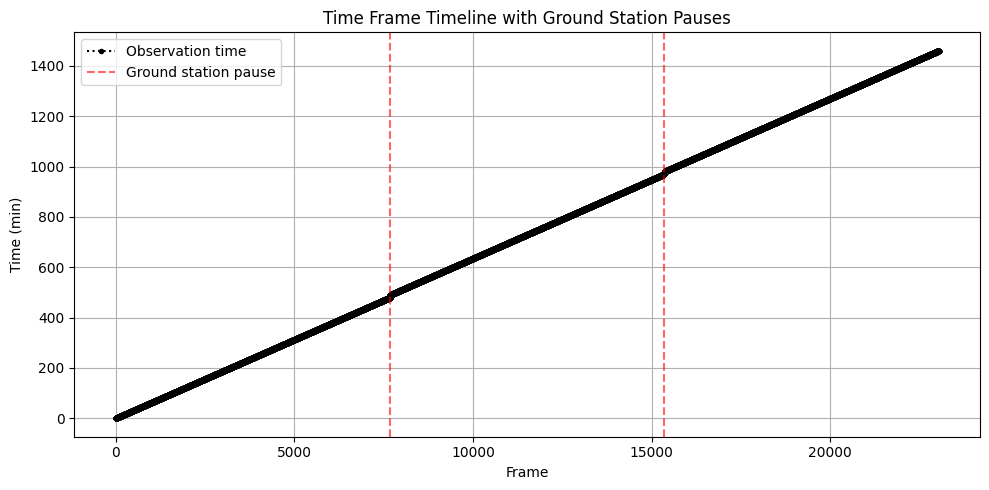

In [25]:
tf_B.plot()

In [26]:
tf_B.max_frames_and_fields_per_day()

📈 Observation budget per day:
→ Daily available time: 1420.0 min
→ Time per frame: 0.062 min
→ Max frames per day: 22720
→ Frames per coordinate: 16
→ Max fields per day (final images): 1420


(22720, 1420)

In [27]:
tf_B.compute_observation_durations()

📊 Observation block durations (between data downloads):
→ Shortest : 479.73 min
→ Longest  : 480.00 min
→ Mean     : 479.84 min


array([479.78125   , 480.        , 479.72916667])

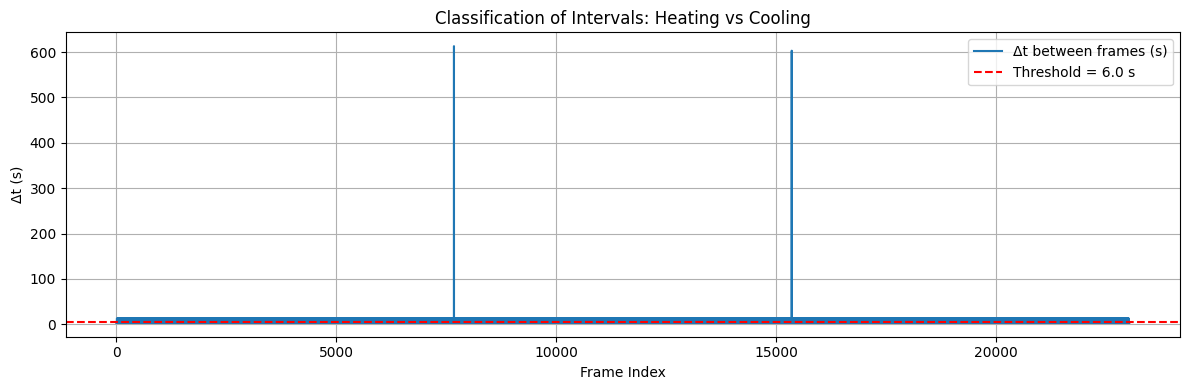

In [28]:
times_B, temps_B, _, _, _ = model.simulate_temperature_from_custom_timeline(
    time_model=tf_B,
    external_temp=0.0,
    exposure_time_min=50/16,
    show_plot=True,
    threshold_buffer_min=0.1-50/16
)

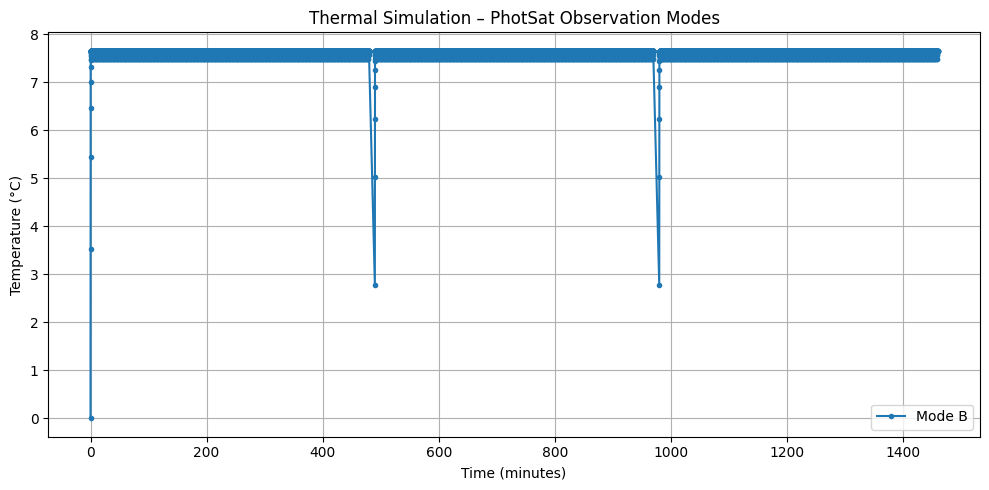

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(times_B/60, temps_B, label="Mode B", marker='.')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Thermal Simulation – PhotSat Observation Modes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:

# MODO C: 16 imágenes de 1s + 2.125s de espera → 3.125s total por imagen
tf_C = Time_frame(
    coordinates_length=1440,
    image_per_coord=16,
    exposition_time=50/16/60,   # minutos por imagen
    pointing_time=10/60,
    daily_pauses=2,
    pause_duration=10,
    min_pause_separation=20
)

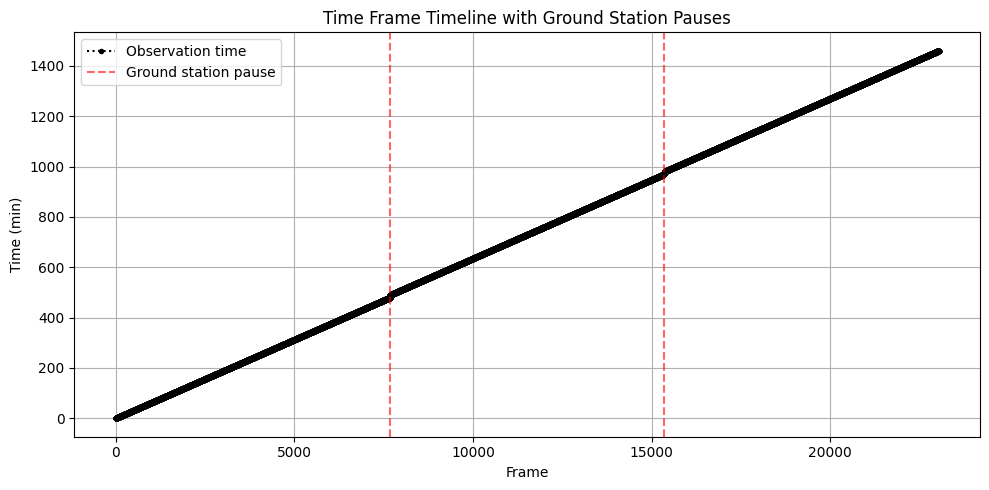

In [31]:
tf_C.plot()

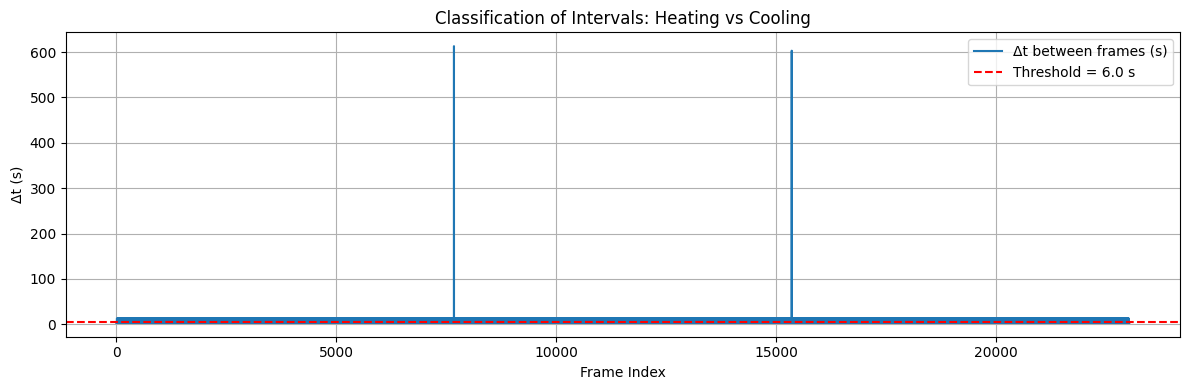

In [32]:

times_C, temps_C, _, _, _ = model.simulate_temperature_from_custom_timeline(
    time_model=tf_C,
    external_temp=0.0,
    exposure_time_min=1,
    frame_pause_min=2.125,
    show_plot=True,
    threshold_buffer_min=0.1-1
)




In [33]:
temps_C

array([0.        , 1.30884433, 1.76278834, ..., 2.00382823, 2.0038283 ,
       2.00382833], shape=(23040,))

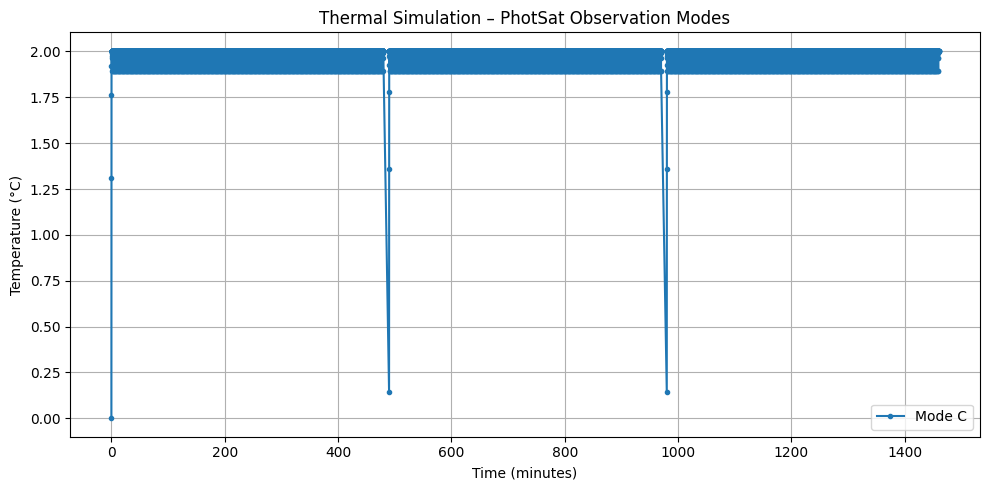

In [34]:
# PLOT COMPARATIVO
plt.figure(figsize=(10, 5))
#plt.plot(times_A, temps_A, label="Mode A", marker='.')
#plt.plot(times_B / 60, temps_B, label="Mode B", marker='.')
plt.plot(times_C / 60, temps_C, label="Mode C", marker='.')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Thermal Simulation – PhotSat Observation Modes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

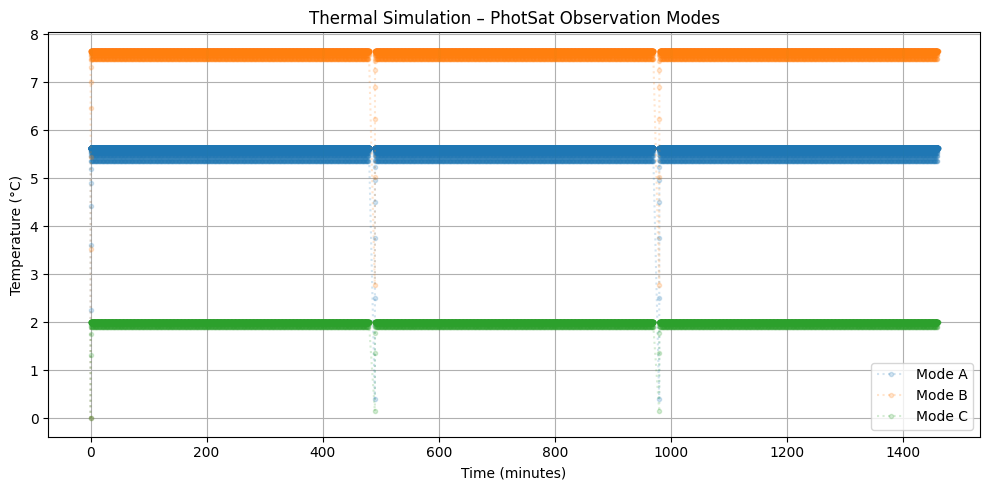

In [35]:
# PLOT COMPARATIVO
plt.figure(figsize=(10, 5))
plt.plot(times_A/60, temps_A, label="Mode A", marker='.', alpha=0.2, ls=":")
plt.plot(times_B / 60, temps_B, label="Mode B", marker='.', alpha=0.2, ls=":")
plt.plot(times_C / 60, temps_C, label="Mode C", marker='.', alpha=0.2, ls=":")
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Thermal Simulation – PhotSat Observation Modes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

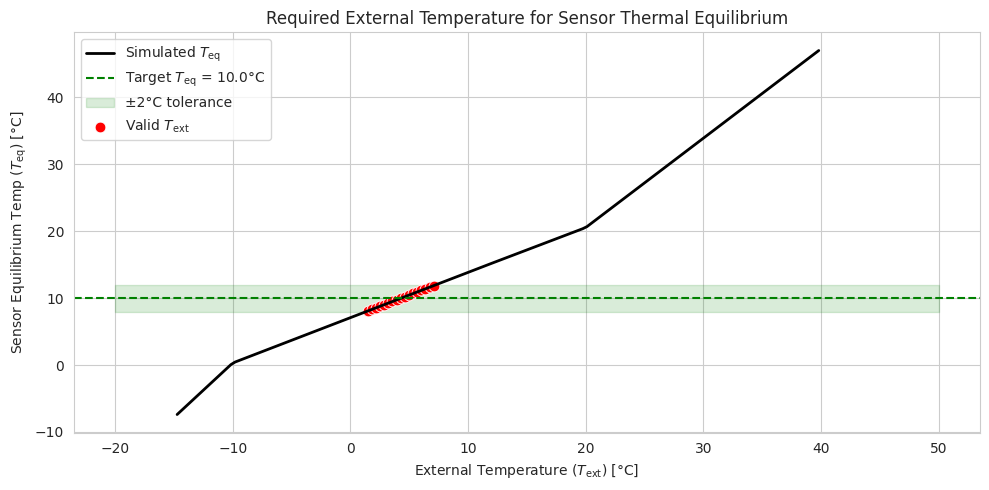

In [36]:
mode_B = {
    "n_frames": 16,
    "n_bursts": 300,
    "frame_pause": 0.1,
    "burst_pause": 10
}

valid_temps = model.find_external_temp_range_for_equilibrium(
    T_eq_target=10,
    exposure_time=3.125,
    mode_params=mode_B,
    tol=2
)



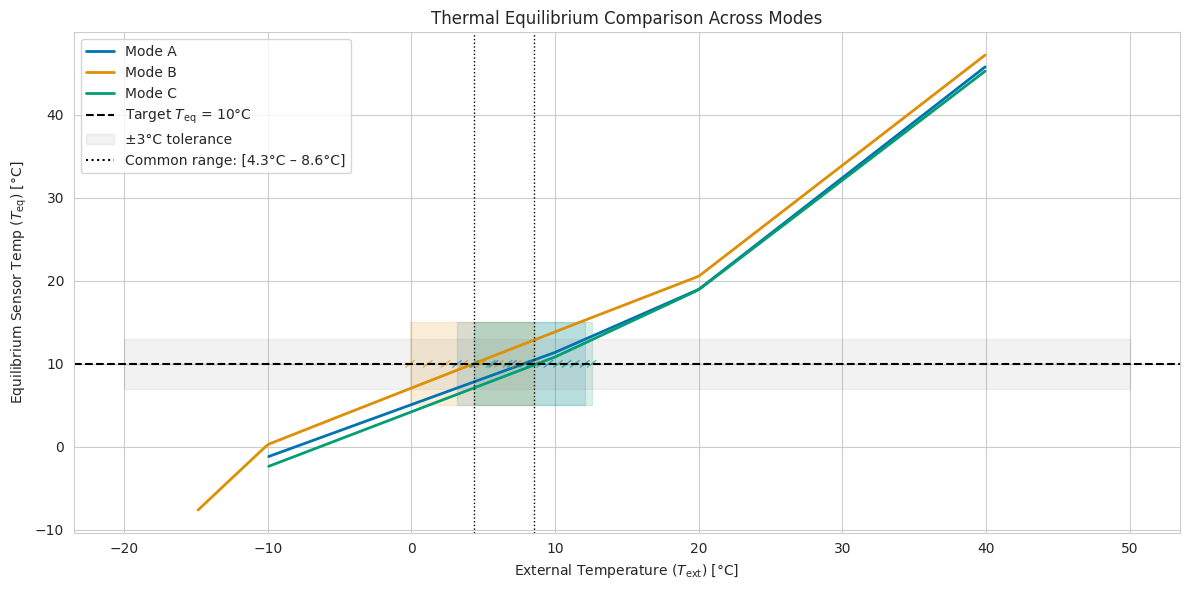

In [40]:
mode_A = {
    "name": "Mode A",
    "exposure_time": 1,
    "n_frames": 50,
    "n_bursts": 50,
    "frame_pause": 0.01,
    "burst_pause": 10
}

mode_B = {
    "name": "Mode B",
    "exposure_time": 3.125,
    "n_frames": 16,
    "n_bursts": 50,
    "frame_pause": 0.01,
    "burst_pause": 10
}

mode_C = {
    "name": "Mode C",
    "exposure_time": 1,
    "n_frames": 16,
    "n_bursts": 50,
    "frame_pause": 2.125,
    "burst_pause": 10
}

common_range, per_mode = model.compare_modes_equilibrium_temperature(
    T_eq_target=10,
    mode_list=[mode_A, mode_B, mode_C],
    tol=3
)
